In [10]:
pip install google-search-results

Note: you may need to restart the kernel to use updated packages.


In [11]:
from serpapi import GoogleSearch
import pandas as pd

# Define the lists of search queries
queries = {
    'gap_q': ['gap shirts', 'gap tops', 'gap jeans', 'gap tshirts', 'gap polo', 'gap pants',
              'gap sweatshirts', 'gap hoodies'],
    'ban_q': ['banana republic shirts', 'banana republic tops', 'banana republic jeans',
              'banana republic tshirts', 'banana republic polo', 'banana republic pants',
              'banana republic sweatshirts', 'banana republic hoodies'],
    'old_q': ['old navy shirts', 'old navy tops', 'old navy jeans', 'old navy tshirts',
              'old navy polo', 'old navy pants', 'old navy sweatshirts', 'old navy hoodies']
}

# SerpApi parameters
params = {
    "engine": "google_shopping",
    "location": "United States",
    "hl": "en",
    "gl": "us",
    "api_key": "cff9bbbf010170e4f6b05f6146d8b9f76425315d59f804bcc04b6d5f0e65ae6b"  # Replace with your actual API key
}

try:
    for query_list_name, query_list in queries.items():
        # Initialize an empty DataFrame for each query list
        results_df = pd.DataFrame()

        # Loop through the queries in the current query list
        for query in query_list:
            params["q"] = query

            # Perform the search
            search = GoogleSearch(params)
            results = search.get_dict()
            shopping_results = results.get("shopping_results", [])

            if shopping_results:
                df = pd.DataFrame(shopping_results)
                # Add a new column to specify the query list name
                df['Query_List'] = query_list_name
                results_df = pd.concat([results_df, df], ignore_index=True)

        # Save results to a separate CSV file for each query list
        results_df.to_csv(f"{query_list_name}_results9.csv", index=False)
        print(f"Data saved to '{query_list_name}_results9.csv'")

except Exception as e:
    print(f"An error occurred: {e}")


Data saved to 'gap_q_results9.csv'
Data saved to 'ban_q_results9.csv'
Data saved to 'old_q_results9.csv'


Data saved to 'gap_q_results10.csv'
Model summary saved to 'gap_q_model_summary.txt'


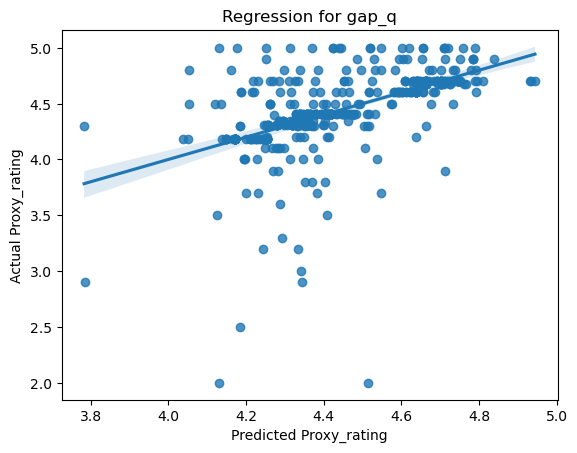

Data saved to 'ban_q_results10.csv'
Model summary saved to 'ban_q_model_summary.txt'


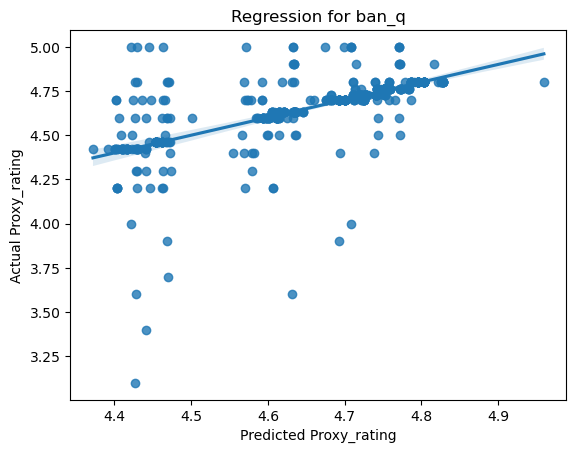

Data saved to 'old_q_results10.csv'
Model summary saved to 'old_q_model_summary.txt'


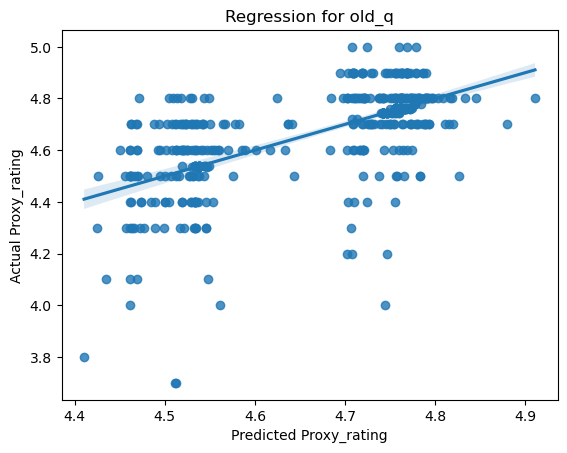

Regression Model for gap_q:
                            OLS Regression Results                            
Dep. Variable:           Proxy_rating   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     11.60
Date:                Sun, 01 Oct 2023   Prob (F-statistic):           1.18e-26
Time:                        20:17:11   Log-Likelihood:                -100.27
No. Observations:                 480   AIC:                             236.5
Df Residuals:                     462   BIC:                             311.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
co

In [5]:
from serpapi import GoogleSearch
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Define the lists of search queries
queries = {
    'gap_q': ['gap shirts', 'gap tops', 'gap jeans', 'gap tshirts', 'gap polo', 'gap pants',
              'gap sweatshirts', 'gap hoodies'],
    'ban_q': ['banana republic shirts', 'banana republic tops', 'banana republic jeans',
              'banana republic tshirts', 'banana republic polo', 'banana republic pants',
              'banana republic sweatshirts', 'banana republic hoodies'],
    'old_q': ['old navy shirts', 'old navy tops', 'old navy jeans', 'old navy tshirts',
              'old navy polo', 'old navy pants', 'old navy sweatshirts', 'old navy hoodies']
}

# Placeholder for the API key
api_key = "cff9bbbf010170e4f6b05f6146d8b9f76425315d59f804bcc04b6d5f0e65ae6b"  # Replace with your actual API key

# Initialize an empty DataFrame for all results
all_results_df = pd.DataFrame()

# SerpApi parameters
params = {
    "engine": "google_shopping",
    "location": "United States",
    "hl": "en",
    "gl": "us",
    "api_key": api_key
}

# Initialize a list to store regression models
regression_models = []

try:
    for query_list_name, query_list in queries.items():
        # Initialize an empty DataFrame for each query list
        results_df = pd.DataFrame()

        # Loop through the queries in the current query list
        for query in query_list:
            params["q"] = query

            # Perform the search
            search = GoogleSearch(params)
            results = search.get_dict()
            shopping_results = results.get("shopping_results", [])

            if shopping_results:
                df = pd.DataFrame(shopping_results)
                # Add a new column to specify the query list name
                df['Query_List'] = query_list_name
                # Add an extra column for the query itself
                df['Query'] = query

                # Convert 'price' and 'old_price' columns to numeric
                df['price'] = pd.to_numeric(df['price'], errors='coerce')
                df['old_price'] = pd.to_numeric(df['old_price'], errors='coerce')

                # Add columns as requested
                df['Proxy_rating'] = df.apply(lambda row: row['rating'] if pd.notnull(row['rating']) else df['rating'].mean(), axis=1)
                df['Proxy_reviews'] = df.apply(lambda row: row['reviews'] if pd.notnull(row['rating']) else df['reviews'].mean(), axis=1)
                df['Discount'] = df.apply(lambda row: row['extracted_price'] - row['extracted_old_price'] if pd.notnull(row['extracted_old_price']) else 0, axis=1)
                df['Promo_1'] = df.apply(lambda row: 1 if row['tag'] == 'LOW PRICE' else 0, axis=1)
                df['Promo_2'] = df.apply(lambda row: 1 if row['tag'] == 'SALE' else 0, axis=1)

                # Check if 'badge' column exists and add 'Proxy_store' accordingly
                if 'badge' in df.columns:
                    df['Proxy_store'] = df.apply(lambda row: 1 if row['badge'] == 'Top Quality Store' else 0, axis=1)
                else:
                    df['Proxy_store'] = 0

                # Create seller-specific columns
                sellers = ['Gap', 'Gap Factory', 'Old Navy', 'Banana', 'Amazon', 'eBay', 'Walmart']
                for i, seller in enumerate(sellers, start=1):
                    df[f'Proxy_seller_{i}'] = df.apply(lambda row: 1 if seller in row['source'] else 0, axis=1)

                results_df = pd.concat([results_df, df], ignore_index=True)

        # Save results to a separate CSV file for each query list
        results_df.to_csv(f"{query_list_name}_results10.csv", index=False)
        print(f"Data saved to '{query_list_name}_results10.csv'")
        
        
        # Perform regression analysis
        X = results_df[['Proxy_reviews', 'Discount', 'Promo_1', 'Promo_2', 'Proxy_store',
                        'Proxy_seller_1', 'Proxy_seller_2', 'Proxy_seller_3', 'Proxy_seller_4',
                        'Proxy_seller_5', 'Proxy_seller_6', 'Proxy_seller_7', 'Query']]
        X = pd.get_dummies(X, columns=['Query'], drop_first=True)  # Create dummy variables for 'Query'
        X = sm.add_constant(X)  # Add a constant for the intercept
        y = results_df['Proxy_rating']

        model = sm.OLS(y, X).fit()
        regression_models.append((query_list_name, model))
        
        # Save model summary to a text file
        with open(f"{query_list_name}_model_summary.txt", "w") as text_file:
            text_file.write(str(model.summary()))
            print(f"Model summary saved to '{query_list_name}_model_summary.txt'")
            
        # Plot regression model evaluation
        sns.regplot(x=model.predict(X), y=y)
        plt.xlabel("Predicted Proxy_rating")
        plt.ylabel("Actual Proxy_rating")
        plt.title(f"Regression for {query_list_name}")
        plt.show()


except Exception as e:
    print(f"An error occurred: {e}")

# Print regression models
for query_list_name, model in regression_models:
    print(f"Regression Model for {query_list_name}:")
    print(model.summary())
    

In [6]:
# Perform t-test picking 2 models at a time
#H0: model1=model2 and model2=model3 and model3=model
#Ha: all three models are different
#significance level = 0.05

from statsmodels.formula.api import ols
from scipy import stats

# List of models
models = [regression_models[i][1] for i in range(len(regression_models))]

# Perform pairwise t-tests between models and collect p-values
p_values = []
for i in range(len(models)):
    for j in range(i + 1, len(models)):
        model1 = models[i]
        model2 = models[j]

        t_stat, p_value = stats.ttest_ind(model1.resid, model2.resid)
        p_values.append(p_value)
        print(f"T-test between Model {i+1} and Model {j+1}:\nT-statistic: {t_stat}\nP-value: {p_value}\n\n")

# Check if all p-values are less than 0.05
if all(p < 0.05 for p in p_values):
    print("Hypothesis testing conclusion: All 3 brands are affected similarly by independent variables like price, discount, no. of reviews, seller, and product category(Query)")
else:
    print("Hypothesis testing conclusion: All 3 brands are affected differently by independent variables like price, discount, no. of reviews, seller, and product category(Query). Hence, GAP Inc. should build a customized big data strategy for each brand.")


T-test between Model 1 and Model 2:
T-statistic: 9.719740154121815e-12
P-value: 0.9999999999922469


T-test between Model 1 and Model 3:
T-statistic: 1.0981297096907509e-11
P-value: 0.9999999999912405


T-test between Model 2 and Model 3:
T-statistic: 1.5540413329070852e-12
P-value: 0.9999999999987603


Hypothesis testing conclusion: All 3 brands are affected differently by independent variables like price, discount, no. of reviews, seller, and product category(Query). Hence, GAP Inc. should build a customized big data strategy for each brand.
